In [1]:
import pathlib
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import astropy as ast
from astropy import stats
import pandas as pd

import SessionTools.two_photon as st2p

plt.rcParams['pdf.fonttype']=42

%load_ext autoreload
%autoreload 2 


%matplotlib inline

In [2]:
basedir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch/ER4d_sytjGCaMP7f_EPG_jRGECO1a')
sess_df = pd.read_csv(basedir / 'sessions.csv')
sess_df['fly_id'] = [row['date']+'_'+row['fly'] for _, row in sess_df.iterrows()]

In [3]:
cl_mask = (sess_df['closed_loop']==1) & (sess_df['usable']==1) & (sess_df['terminals_only']==1)
cl_mask.sum()

dark_mask = (sess_df['closed_loop']==0) & (sess_df['open_loop']==0) &(sess_df['usable']==1) & (sess_df['terminals_only']==1)
dark_mask.sum()

2

In [4]:
sess_df = sess_df.loc[cl_mask]

In [5]:
tethered_mask = np.array([0,0,1,0,1,1,0,1,1,1,1,1,1,0,1,0,0,1,1,1])>0
sess_df = sess_df.loc[tethered_mask]

In [6]:
sess_df['fly_id'].unique().shape

(5,)

In [7]:
figfolder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/cosyne_2024/poster/antibump/')

In [8]:
def get_ts(pp, coef = .7):
    y_r4d = pp.timeseries['rois_R4d_z']
    y_epg = pp.timeseries['rois_EB_z']
    heading = -1*pp.voltage_recording_aligned[' Heading'].to_numpy()
    bar_vis_mask = np.abs(heading)>1.5
    # print(sp.stats.pearsonr(y_epg[1,5,:],y_epg[0,5,:]))
    
    y_r4d[1,:,:] = np.maximum(y_r4d[1,:,:] - coef*y_r4d[0,:,:],0) + coef*y_r4d[0,:,:].mean(axis=-1,keepdims=True)
    
    # y_r4d[1,:,:] = np.roll(y_r4d[1,:,:],0,axis=-1) - coef*y_r4d[0,:,:] + coef*y_r4d[0,:,:].mean(axis=-1,keepdims=True)
    # y_r4d -= y_r4d.mean(axis=1,keepdims=True)
    y_r4d_sm = sp.ndimage.gaussian_filter1d(sp.ndimage.gaussian_filter1d(y_r4d-1, 2, axis=-1),.7,axis=1, mode='wrap')
    
    
    y_epg[0,:,:] = np.maximum(y_epg[0,:,:]-coef*y_epg[1,:,:],0) + coef*y_epg[1,:,:].mean(axis=-1,keepdims=True)
    # y_epg[0,:,:] = y_epg[0,:,:]-coef*y_epg[1,:,:] + coef*y_epg[1,:,:].mean(axis=-1,keepdims=True)
    # y_epg -= y_epg.mean(axis=1,keepdims=True)
    y_epg_sm = sp.ndimage.gaussian_filter1d(sp.ndimage.gaussian_filter1d(y_epg-1, 2, axis=-1),.7,axis=1, mode='wrap')
    
    
    n_rois = y_r4d.shape[1]
    x_f,y_f = st2p.utilities.pol2cart(y_r4d_sm[1,:,:] ,np.linspace(-np.pi,np.pi,num=n_rois)[:,np.newaxis])
    rho_r4d, phi_r4d = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))

    x_f,y_f = st2p.utilities.pol2cart(y_epg_sm[0,:,:],np.linspace(-np.pi,np.pi,num=n_rois)[:,np.newaxis])
    rho_epg, phi_epg = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))

    _,offset_r4d = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi_r4d-heading))
    _,offset_epg = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi_epg-heading))
    
    return {'heading': heading,
            'bar_vis_mask': bar_vis_mask,
            'y_r4d': y_r4d,
            'y_epg': y_epg,
            'y_r4d_sm': y_r4d_sm,
            'y_epg_sm': y_epg_sm,
            'rho_r4d': rho_r4d,
            'phi_r4d': phi_r4d,
            'offset_r4d': offset_r4d,
            'rho_epg': rho_epg,
            'phi_epg': phi_epg,
            'offset_epg': offset_epg}

def align_to_heading(ts):
    heading_bins = np.linspace(-np.pi, np.pi, num=17)
    heading_dig = np.digitize(ts['heading'], heading_bins)-1

    y_h_aligned = np.zeros_like(ts['y_epg_sm'])
    for ind in range(ts['heading'].shape[0]):
        y_h_aligned[0,:,ind] = np.roll(ts['y_epg_sm'][0,:,ind], -heading_dig[ind])
        y_h_aligned[1,:,ind] = np.roll(ts['y_r4d_sm'][1,:,ind], -heading_dig[ind])
        
    y_h_aligned_z = np.zeros((2,16,16))
    for b in range(16):
        mask = heading_dig==b
        y_h_aligned_z[:,:,b] = y_h_aligned[:,:,mask].mean(axis=-1)
    
    # y_h_aligned = sp.stats.zscore(y_h_aligned,axis=1)
    
    # y_h_aligned_z = sp.stats.zscore(y_h_aligned, axis=1)
    
    return heading_bins, y_h_aligned, y_h_aligned_z

   

In [9]:
heading_bins = np.linspace(-np.pi, np.pi, num=17)
centers = (heading_bins[:-1] + heading_bins[1:])/2

In [10]:
epg_avg = []
r4d_avg = []

epg_avg_b = []
r4d_avg_b = []

offset_var = []
for _, row in sess_df.iterrows():
    outdir = pathlib.PurePath( basedir / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
    pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
    ts = get_ts(pp, coef=0.0)


    heading_bins,y_h_aligned_z, y_h_aligned_norm = align_to_heading(ts)
    centers = (heading_bins[:-1] + heading_bins[1:])/2


    
    ha_avg_epg = sp.stats.zscore(y_h_aligned_z[0,:,:][:,ts['bar_vis_mask']].mean(axis=-1))
    # ha_avg_epg = y_h_aligned_z[0,:,:][:,np.abs(centers)>1].mean(axis=-1)
   

    ha_avg_r4d = sp.stats.zscore(y_h_aligned_z[1,:,:][:,ts['bar_vis_mask']].mean(axis=-1))
    # ha_avg_r4d = y_h_aligned_z[1,:,:][:,np.abs(centers)>1].mean(axis=-1)
    
    
    ha_avg_epg_b = sp.stats.zscore(y_h_aligned_z[0,:,:][:,~ts['bar_vis_mask']].mean(axis=-1))
    # ha_avg_epg_b = y_h_aligned_z[0,:,:][:,np.abs(centers)<1].mean(axis=-1)
    
    

    ha_avg_r4d_b = sp.stats.zscore(y_h_aligned_z[1,:,:][:,~ts['bar_vis_mask']].mean(axis=-1))
    # ha_avg_r4d_b = y_h_aligned_z[1,:,:][:,np.abs(centers)<1].mean(axis=-1)
    
    


    argmax_epg = np.argmax(ha_avg_epg)
    
    epg_avg.append(np.roll(ha_avg_epg, -argmax_epg-8))
    r4d_avg.append(np.roll(ha_avg_r4d, -argmax_epg-8))
    
    argmax_epg_b = np.argmax(ha_avg_epg_b)
    epg_avg_b.append(np.roll(ha_avg_epg_b, -argmax_epg_b-8))
    r4d_avg_b.append(np.roll(ha_avg_r4d_b, -argmax_epg_b-8))
    
    
    offset_var.append(sp.stats.circvar(ts['offset_epg'][ts['bar_vis_mask']]))
    # ha_avg_epg_centered = np.roll(ha_avg_epg, -argmax_epg-7)
    # ha_avg_r4d_centered = np.roll(ha_avg_r4d, -argmax_epg-7)

# epg_avg = sp.stats.zscore(np.array(epg_avg),axis=1)
# r4d_avg = sp.stats.zscore(np.array(r4d_avg), axis=1)
epg_avg = np.array(epg_avg)
r4d_avg = np.array(r4d_avg)

# epg_avg_b = sp.stats.zscore(np.array(epg_avg_b),axis=1)
# r4d_avg_b = sp.stats.zscore(np.array(r4d_avg_b), axis=1)
epg_avg_b = np.array(epg_avg_b)
r4d_avg_b = np.array(r4d_avg_b)

offset_var = np.array(offset_var)
print(epg_avg.shape, r4d_avg.shape)

(7, 16) (7, 16)


In [11]:
epg_avg_red, r4d_avg_red, epg_avg_b_red, r4d_avg_b_red, offset_var_red = [],[],[],[], []
for fly in sess_df['fly_id'].unique():
    mask = sess_df['fly_id']==fly
    epg_avg_red.append(epg_avg[mask,:].mean(axis=0)) 
    r4d_avg_red.append(r4d_avg[mask,:].mean(axis=0)) 
    epg_avg_b_red.append(epg_avg_b[mask,:].mean(axis=0)) 
    r4d_avg_b_red.append(r4d_avg_b[mask,:].mean(axis=0)) 
    offset_var_red.append(offset_var[mask].mean())
    
epg_avg_red = np.array(epg_avg_red)
r4d_avg_red = np.array(r4d_avg_red)

epg_avg_b_red = np.array(epg_avg_b_red)
r4d_avg_b_red = np.array(r4d_avg_b_red)
offset_var_red = np.array(offset_var_red)
    

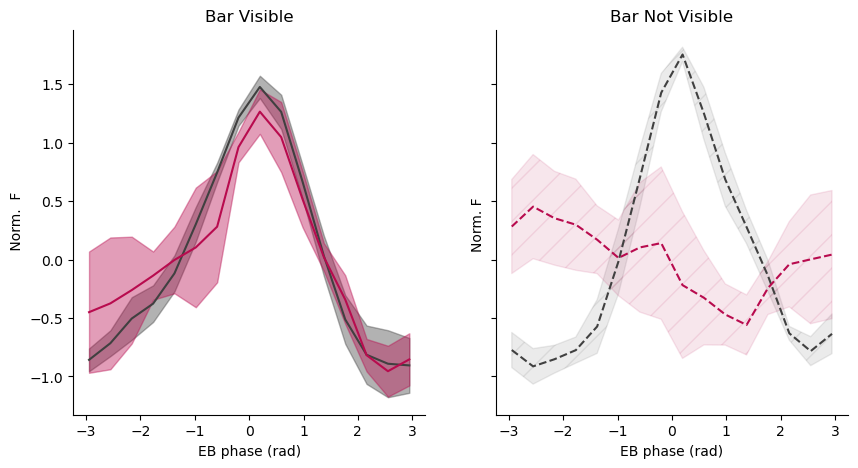

In [12]:
heading_bins = np.linspace(-np.pi, np.pi, num=17)
centers = (heading_bins[:-1] + heading_bins[1:])/2

fig, ax = plt.subplots(1,2,sharey=True, sharex=True, figsize=[10,5])
offset_var_mask = offset_var_red<1

mu, sem = epg_avg_red[offset_var_mask,:].mean(axis=0), sp.stats.sem(epg_avg_red[offset_var_mask,:],axis=0)
ax[0].plot(centers, mu, color=plt.cm.Greys(.8))
ax[0].fill_between(centers, mu-sem, mu+sem, color=plt.cm.Greys(.8), alpha=.4)

mu, sem = r4d_avg_red[offset_var_mask,:].mean(axis=0), sp.stats.sem(r4d_avg_red[offset_var_mask,:],axis=0)
ax[0].plot(centers, mu, color=plt.cm.PuRd(.8))
# ax[0].plot(centers,np.ones_like(centers)*mu.mean(), linestyle='dotted', color=plt.cm.PuRd(1.))
ax[0].fill_between(centers, mu-sem, mu+sem, color=plt.cm.PuRd(.8), alpha=.4)



mu, sem = epg_avg_b_red.mean(axis=0), sp.stats.sem(epg_avg_b_red,axis=0)
ax[1].plot(centers, mu, color=plt.cm.Greys(.8), linestyle= '--')
ax[1].fill_between(centers, mu-sem, mu+sem, color=plt.cm.Greys(.8), alpha=.1,hatch='/')

mu, sem = r4d_avg_b_red.mean(axis=0), sp.stats.sem(r4d_avg_b_red,axis=0)
ax[1].plot(centers, mu, color=plt.cm.PuRd(.8), linestyle='--')
_m = r4d_avg_red.mean(axis=0)
# ax[1].plot(centers,np.ones_like(centers)*_m.mean(), linestyle = 'dotted', color=plt.cm.PuRd(1.))
ax[1].fill_between(centers, mu-sem, mu+sem, color=plt.cm.PuRd(.8), alpha=.1, hatch='/')


for i in range(2):
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    
ax[0].set_ylabel(" Norm.  F")
ax[0].set_xlabel('EB phase (rad)')
ax[1].set_ylabel("Norm. F ")
ax[1].set_xlabel('EB phase (rad)')
ax[0].set_title('Bar Visible')
ax[1].set_title('Bar Not Visible')

fig.savefig(figfolder / 'EPG_centered.pdf', format='pdf')

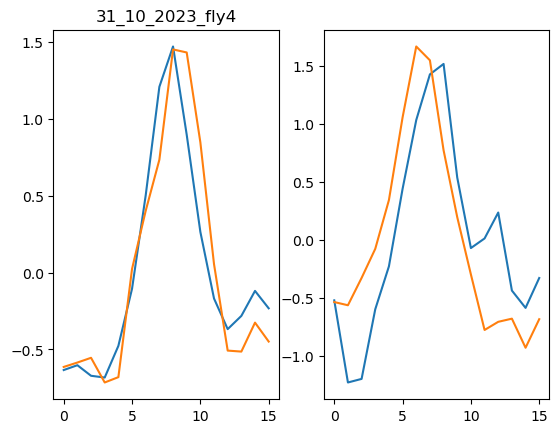

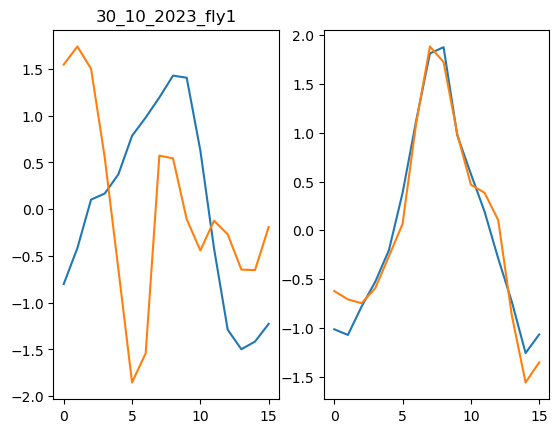

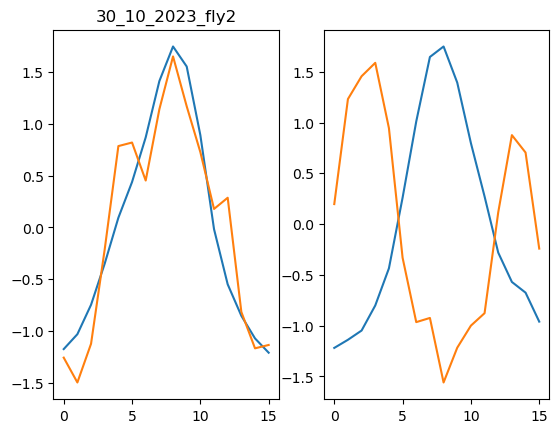

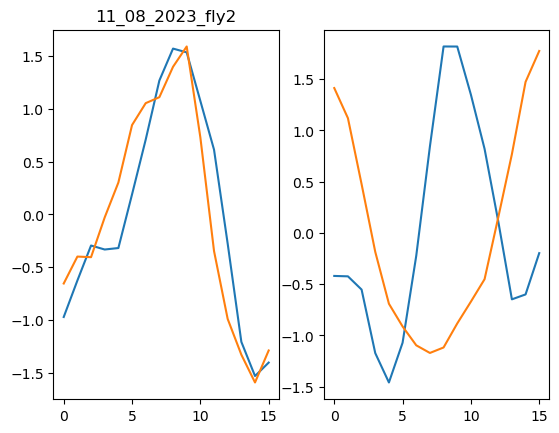

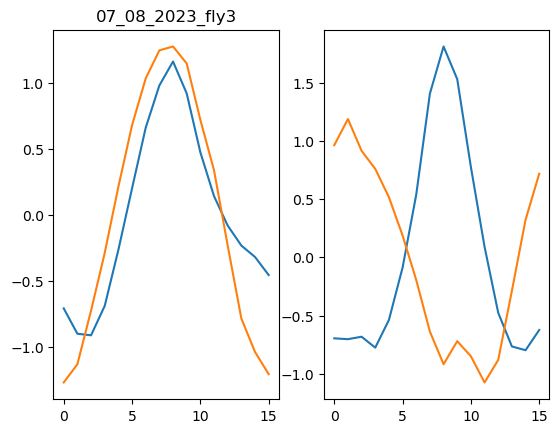

In [13]:
fly_ids = sess_df['fly_id'].unique()
for e in range(epg_avg_red.shape[0]):
    fig,ax = plt.subplots(1,2)
    ax[0].plot(epg_avg_red[e,:])
    ax[0].plot(r4d_avg_red[e,:])
    ax[0].set_title(fly_ids[e])
    
    ax[1].plot(epg_avg_b_red[e,:])
    ax[1].plot(r4d_avg_b_red[e,:])
    # ax[0].set_title(fly_ids[e])

In [14]:
t,p = sp.stats.ttest_1samp(r4d_avg_red[:,[7,8,9]].mean(axis=-1)-r4d_avg_red[:,[4,5,11,12]].mean(axis=-1),0)
print(t,p)

t,p = sp.stats.ttest_1samp(r4d_avg_red[:,[8]].mean(axis=-1)-r4d_avg_b_red[:,[8]].mean(axis=-1),0)
print(t,p)

8.790798938745347 0.0009235722630630898
1.8923173136089542 0.13139855607524353


In [15]:
peak_diff = np.abs(8-np.argmax(r4d_avg_red,axis=1))
peak_diff_b = np.abs(8-np.argmax(r4d_avg_b_red,axis=1))
print(peak_diff.mean())
print(peak_diff_b.mean())
u,p = sp.stats.wilcoxon(peak_diff,peak_diff_b)
print(u,p)


1.6
4.4
3.5 0.3125


In [16]:
autocorr = []
for _, row in sess_df.iterrows():
    outdir = pathlib.PurePath( basedir / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
    pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
    ts = get_ts(pp)
    y_autocorr = np.zeros((ts['y_r4d_sm'].shape[1], ts['y_r4d_sm'].shape[-1]))
    for t in range(y_autocorr.shape[-1]):
        data = ts['y_r4d_sm'][1,:,t]
        max_lag = data.shape[0] 
        y_autocorr[:,t] = [sp.stats.pearsonr(data, np.roll(data,-i,axis=0))[0] for i in range(0,max_lag)]
    autocorr.append(y_autocorr[:,ts['bar_vis_mask']].mean(axis=-1))
autocorr = np.array(autocorr)
print(autocorr.shape)

(7, 16)


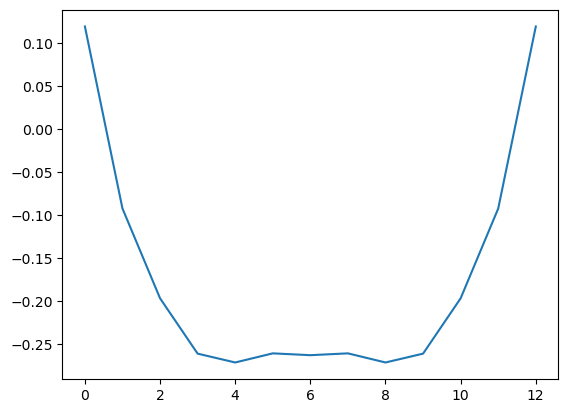

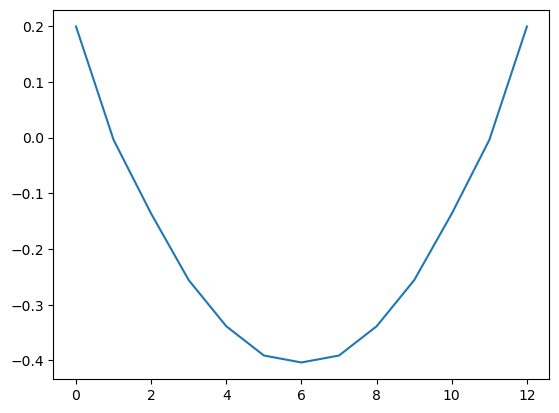

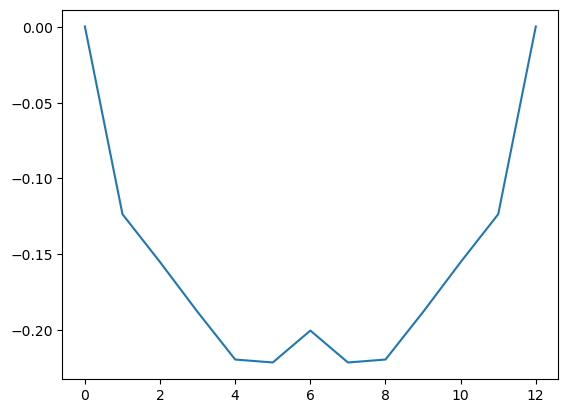

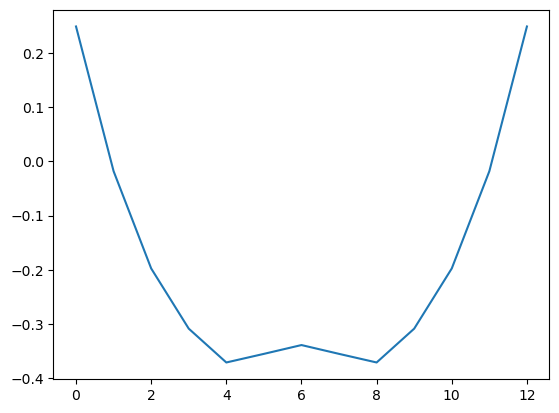

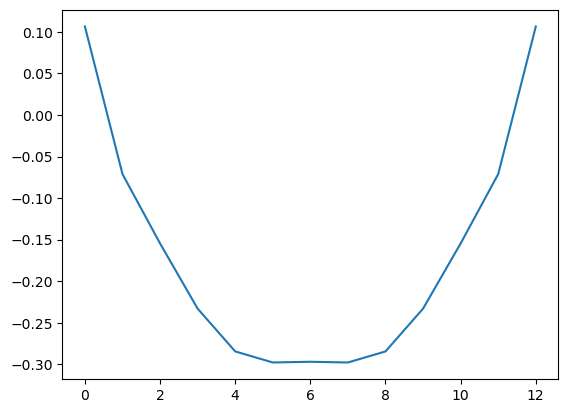

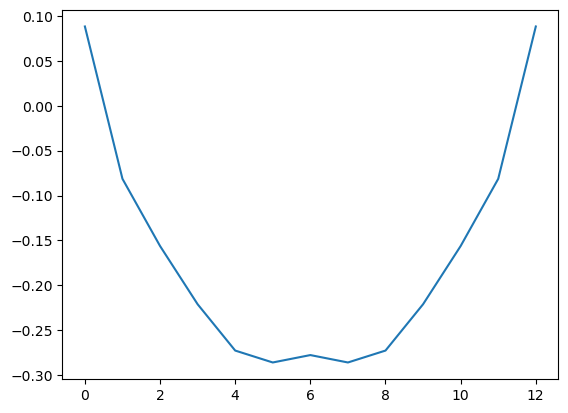

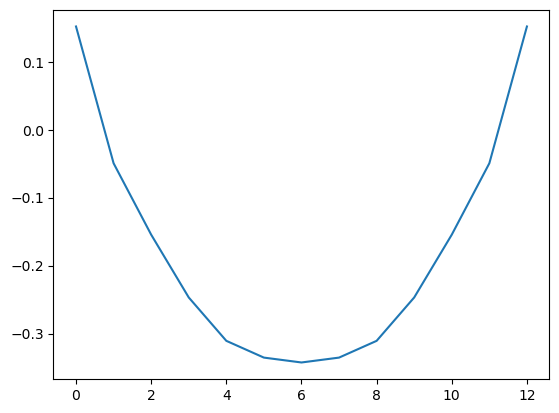

In [17]:
for e in range(autocorr.shape[0]):
    fig, ax = plt.subplots()
    ax.plot(autocorr[e,2:-1])
    

In [18]:
pp.metadata['layout']

{'sequences': 2185, 'frames_per_sequence': 8, 'samples_per_pixel': 5}

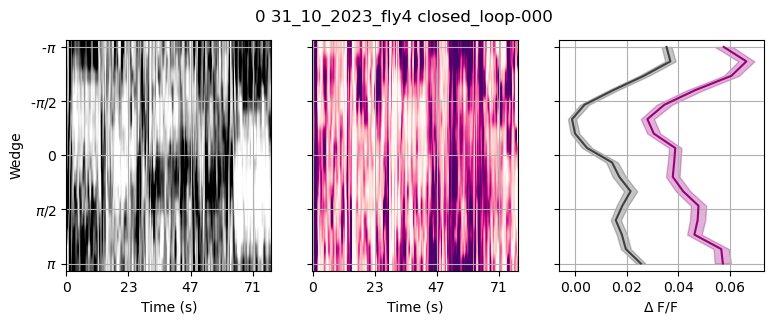

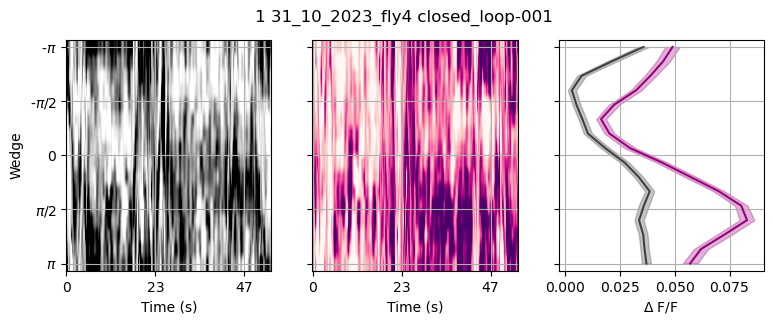

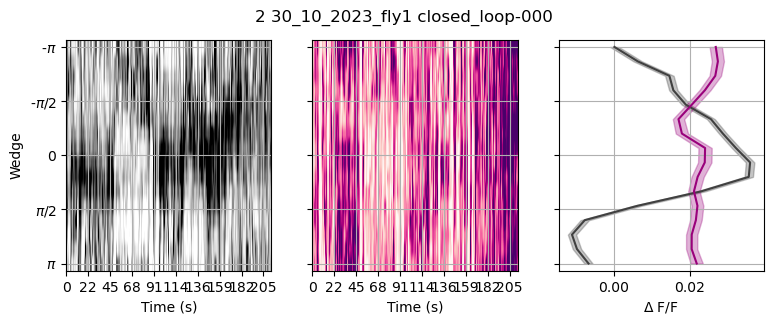

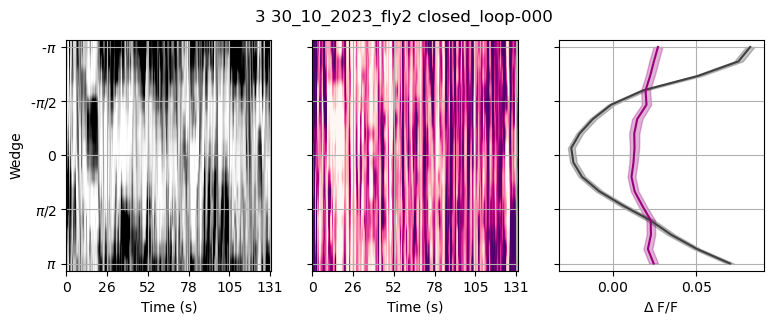

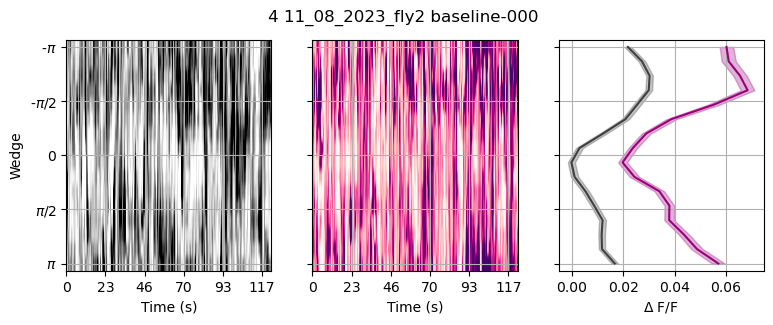

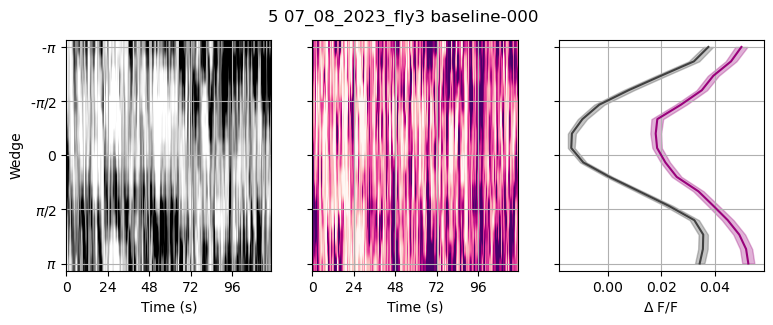

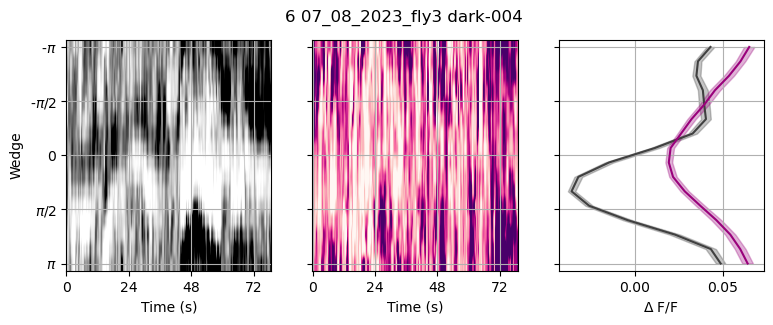

In [19]:
for i, (_, row) in enumerate(sess_df.iterrows()):
    outdir = pathlib.PurePath( basedir / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
    pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
    ts = get_ts(pp,coef=0)
    bins = np.arange(16)
    heading_bins, y_h_aligned, y_h_aligned_z = align_to_heading(ts)
    
    # print(pp.voltage_recording_aligned['Time(ms)'])
    dt = pp.metadata['frame_period']*pp.metadata['layout']['frames_per_sequence']
    
    fig, ax=plt.subplots(1,3, figsize=[9,3], sharex = False, sharey=True)
    ax[0].imshow(y_h_aligned[0,:,:][:,ts['bar_vis_mask']],aspect='auto',cmap='Greys', 
                 vmin=np.percentile(y_h_aligned[0,:,:][:,ts['bar_vis_mask']],10), 
                 vmax=np.percentile(y_h_aligned[0,:,:][:,ts['bar_vis_mask']],90))
    ax[1].imshow(y_h_aligned[1,:,:][:,ts['bar_vis_mask']],aspect='auto', cmap='RdPu',
                vmin=np.percentile(y_h_aligned[1,:,:][:,ts['bar_vis_mask']],10), 
                 vmax=np.percentile(y_h_aligned[1,:,:][:,ts['bar_vis_mask']],90))#,vmin=-.1,vmax=.2)
    
    mu = y_h_aligned[0,:,:][:,ts['bar_vis_mask']].mean(axis=-1)
    sem = sp.stats.sem(y_h_aligned[0,:,:][:,ts['bar_vis_mask']], axis=-1)
    ax[2].plot(mu, bins, color=plt.cm.Greys(.8))
    ax[2].fill_betweenx(bins, mu-sem, mu+sem, color= plt.cm.Greys(.8), alpha = .3)
    
    mu = y_h_aligned[1,:,:][:,ts['bar_vis_mask']].mean(axis=-1)
    sem = sp.stats.sem(y_h_aligned[1,:,:][:,ts['bar_vis_mask']], axis=-1)
    ax[2].plot(mu,bins, color=plt.cm.RdPu(.8))
    ax[2].fill_betweenx(bins, mu-sem, mu+sem, color=plt.cm.RdPu(.8), alpha=.3)
    
    fig.suptitle(f"{i} {row['fly_id']} {row['sess']}")
    for a in range(3):
        ax[a].set_yticks([r/2/np.pi*15 for r in (0,  np.pi/2,  np.pi,  6*np.pi/4,  2*np.pi)], 
                                                 labels = [r'-$\pi$',  r'-$\pi$/2',  '0',  r'$\pi$/2',  r'$\pi$'])
    
    
    t = np.arange(0,dt*y_h_aligned[:,:,ts['bar_vis_mask']].shape[-1], dt)
    ax[0].set_xticks(np.arange(t.shape[0])[::200], labels=[int(_t) for _t in  t[::200]])
    ax[1].set_xticks(np.arange(t.shape[0])[::200], labels=[int(_t) for _t in  t[::200]])
    # ax[0].scatter(np.arange(ts['bar_vis_mask'].sum()),15*((ts['offset_epg'][ts['bar_vis_mask']]+np.pi))/2/np.pi)
    ax[0].set_xlabel('Time (s)')
    ax[1].set_xlabel('Time (s)')
    ax[0].set_ylabel('Wedge')
    ax[2].set_xlabel(r"$\Delta$ F/F")
    ax[0].grid(True)
    ax[1].grid(True)
    ax[2].grid(True)
    fig.savefig(figfolder / f"{row['fly_id']}_{row['sess']}_centered.pdf", format='pdf')

In [51]:
eg_fly = '06_11_2023_fly1'
row = sess_df.loc[sess_df['fly_id'] == eg_fly].iloc[0]

# eg_fly = '22_02_2024_fly1'
# row = sess_df.loc[sess_df['fly_id'] == eg_fly].iloc[0]

# eg_fly = '12_10_2023_fly2'
# row = sess_df.loc[sess_df['fly_id'] == eg_fly].iloc[0]

# eg_fly = '11_08_2023_fly3'
# row = sess_df.loc[sess_df['fly_id'] == eg_fly].iloc[0]


In [52]:
outdir = pathlib.PurePath( basedir / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
ts = get_ts(pp,coef=0)

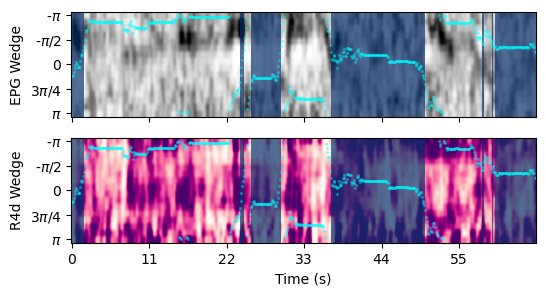

In [53]:
window = slice(200,800)
fig, ax= plt.subplots(2,1, figsize=[6,3], sharex=True)
ax[0].imshow(ts['y_epg_sm'][0,:,window], aspect='auto', cmap= 'Greys',vmin=-.1,vmax=.2)
ax[1].imshow(ts['y_r4d_sm'][1,:,window], aspect='auto', cmap= 'RdPu', vmin=-.1, vmax=.2)


x = np.arange(ts['y_epg'].shape[-1])
fill = np.ones_like(ts['y_r4d_sm'][1,:,:])
fill[:, ts['bar_vis_mask']]=np.nan
ax[0].imshow(fill[:,window], aspect='auto', cmap='Blues', vmax=1, vmin=0, alpha=.7)
ax[1].imshow(fill[:,window], aspect='auto', cmap='Blues', vmax=1, vmin=0, alpha=.7)
                   

heading_ = 15*(ts['heading']+np.pi)/2/np.pi
_x = x[window] - x[window][0]
ax[0].scatter(_x, heading_[window], alpha=.3, s=2, color='cyan')
ax[1].scatter(_x , heading_[window], alpha=.3, s=2, color='cyan')

dt = pp.metadata['frame_period']*pp.metadata['layout']['frames_per_sequence']
t = np.arange(0,_x.shape[0]*dt, dt)
_ = ax[1].set_xticks(_x[::100], labels=[int(_t) for _t in t[::100]])


_ = ax[0].set_yticks([r/2/np.pi*15 for r in (0,  np.pi/2,  np.pi,  6*np.pi/4,  2*np.pi)], 
                    labels = [r'-$\pi$',  r'-$\pi$/2',  '0',  r'3$\pi$/4',  r'$\pi$'])
_ = ax[1].set_yticks([r/2/np.pi*15 for r in (0,  np.pi/2,  np.pi,  6*np.pi/4,  2*np.pi)], 
                    labels = [r'-$\pi$',  r'-$\pi$/2',  '0',  r'3$\pi$/4',  r'$\pi$'])

ax[1].set_xlabel('Time (s)')
ax[0].set_ylabel('EPG Wedge')
ax[1].set_ylabel('R4d Wedge')

fig.savefig(figfolder / f"{row['fly_id']}_{row['sess']}_example.pdf", format='pdf')

# # # print(y.shape, heading.shape)
# # # ax[2].scatter(x,heading)
# # ax[1].scatter(_x-_x[0], 15*(ts['phi_epg'][window]+np.pi)/2/np.pi, color=plt.cm.Greys(.8), alpha = 1, s=2)
# # ax[2].scatter(x, phi_r4d, color=plt.cm.RdPu(.8), alpha = .4, s=2)
# # ax[3].scatter(x, offset_epg, color=plt.cm.Greys(.8), alpha = .4, s=2)
# # ax[3].scatter(x, offset_r4d, color=plt.cm.RdPu(.8), alpha = .4, s=2)

# heading_bins, y_h_aligned, y_h_aligned_z = align_to_heading(ts)
# fig, ax=plt.subplots()
# ax.plot(y_h_aligned[0,:,:][:,ts['bar_vis_mask']].mean(axis=-1))
# ax.plot(y_h_aligned[1,:,:][:,ts['bar_vis_mask']].mean(axis=-1))


# fig, ax=plt.subplots(1,2)
# ax[0].imshow(y_h_aligned[0,:,:][:,ts['bar_vis_mask']],aspect='auto',cmap='Greys')
# ax[1].imshow(y_h_aligned[1,:,:][:,ts['bar_vis_mask']],aspect='auto', cmap='RdPu',vmin=-.1,vmax=.4)